# Data Mining Project @ E-commerce Data

#### Dimitris Chortarias Data Scientist



## Loading Data & Packages

In [1]:
# K-Means, CURE, DBSCAN
!pip install pyclustering
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pyclustering.cluster.cure import cure
from pyclustering.cluster import cluster_visualizer
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn import metrics
from sklearn.cluster import DBSCAN
%matplotlib inline

df=pd.read_csv('../input/ecommerce-data/data.csv',encoding='iso-8859-1')
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

     |████████████████████████████████| 2.6 MB 4.4 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.9.3.1-py3-none-any.whl size=2599359 sha256=ed2d103fd68b5d60632af6743d3e058c82ba97f9376ed0a5cf91c40345d5ce7f
  Stored in directory: /root/.cache/pip/wheels/20/23/2f/6c458c4771b29be048cda23e876061a6864ecfc7a9ae2ccf39
Successfully built pyclustering


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Analysis & Preproccessing

### Exploring Dataset

In [2]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Outliers

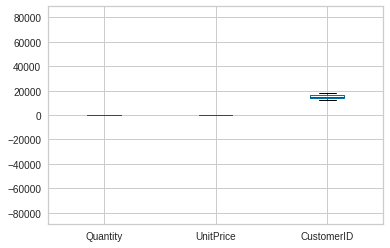

In [3]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot()

### Removing Null Values & filter Data on Quantity to be Positive

In [4]:
df=df.dropna().reset_index()
df = df[df.Quantity <=10000]
df = df[df.Quantity >=0]
df=df.sort_values(['Quantity'],ascending=False)
df.shape

(397921, 9)

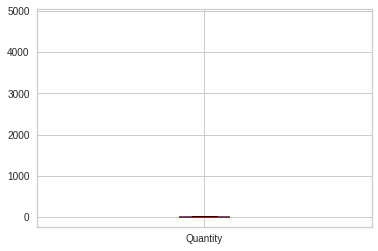

In [5]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot('Quantity')

### Countries Contribution at Dataset 

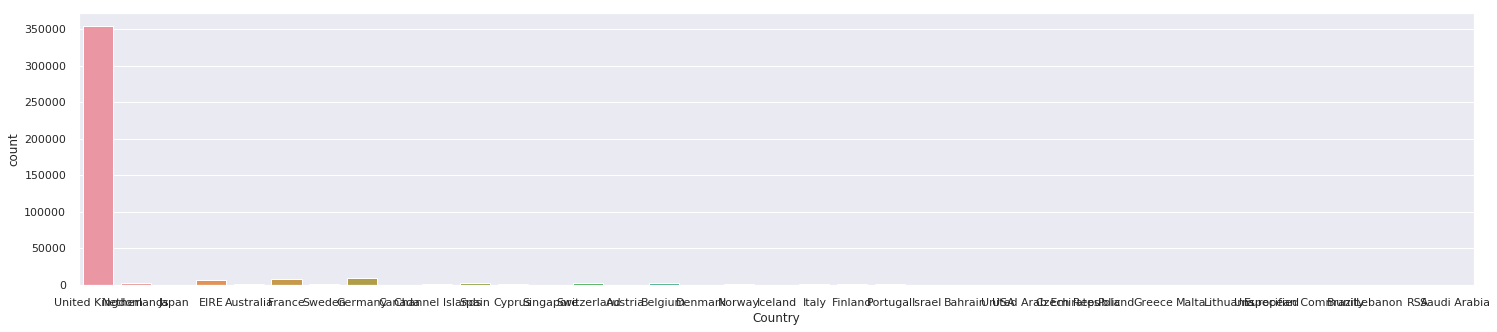

In [6]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Country", data=df)

### Selecting only UK due to sample size

In [7]:
dfuk=df[df['Country']=='United Kingdom']



### Creating the metrics per Customers due to create the customer Segmentation

We are going to run the project based on how much times does the customer bought, average price of the items that he buys and quantity per buy. 

In [8]:
dfukg = (dfuk.groupby(['CustomerID','Country'],as_index=False)
          .agg({'InvoiceNo':'nunique', 'StockCode':'nunique','UnitPrice':'mean','Quantity':'sum'}))
dfukg
dfukg.reset_index()
dfukg['avgitems']=dfukg['Quantity']/dfukg['InvoiceNo']
db=dfukg[['InvoiceNo','UnitPrice','avgitems']]



### Mark and Removing the outliers

In [9]:
import numpy as np

i=0 
while i<=len(db)-1:
    quartile_1, quartile_3 = np.percentile(db['avgitems'], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr *1.5 )
    upper_bound = quartile_3 + (iqr *1.5)
    
    if db.loc[i,'avgitems']> upper_bound:
        db.loc[i,'outlier']=1
    elif db.loc[i,'avgitems']< lower_bound:
        db.loc[i,'outlier']=1
    else:
        db.loc[i,'outlier']=0
    i=i+1
    
db

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,InvoiceNo,UnitPrice,avgitems,outlier
0,11,4.367864,115.909091,0.0
1,210,2.655701,122.609524,0.0
2,5,4.999950,294.200000,0.0
3,4,1.904746,180.500000,0.0
4,1,2.498333,70.000000,0.0
...,...,...,...,...
3914,1,4.765000,45.000000,0.0
3915,1,5.622857,54.000000,0.0
3916,2,5.199167,51.500000,0.0
3917,16,1.614987,87.312500,0.0


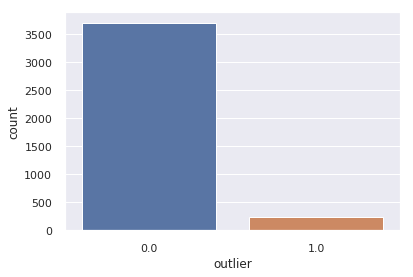

In [10]:
ax = sns.countplot(x="outlier", data=db)

In [11]:
db=db[db['outlier']==0]
db= db.drop(columns=['outlier'])
db

,InvoiceNo,UnitPrice,avgitems
0,11,4.367864,115.909091
1,210,2.655701,122.609524
2,5,4.999950,294.200000
3,4,1.904746,180.500000
4,1,2.498333,70.000000
...,...,...,...
3913,1,3.283333,66.000000
3914,1,4.765000,45.000000
3915,1,5.622857,54.000000
3916,2,5.199167,51.500000


## K-Means with not normalized data

### Elbow Method

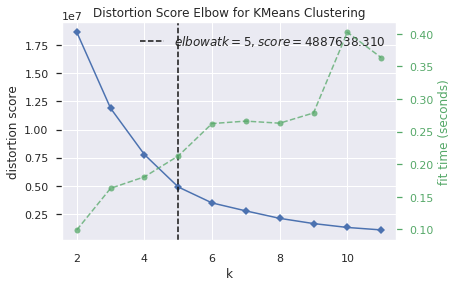

In [12]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(db)  
visualizer.show()        

### Kmeans

[[4.49860724e+00 2.68624629e+00 4.00937163e+02]
 [4.46489104e+00 3.06162468e+00 1.55997996e+02]
 [3.32646834e+00 5.73027434e+00 6.68524971e+01]
 [4.85659898e+00 2.69354075e+00 2.64625183e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]]
[1 1 3 ... 2 2 2]


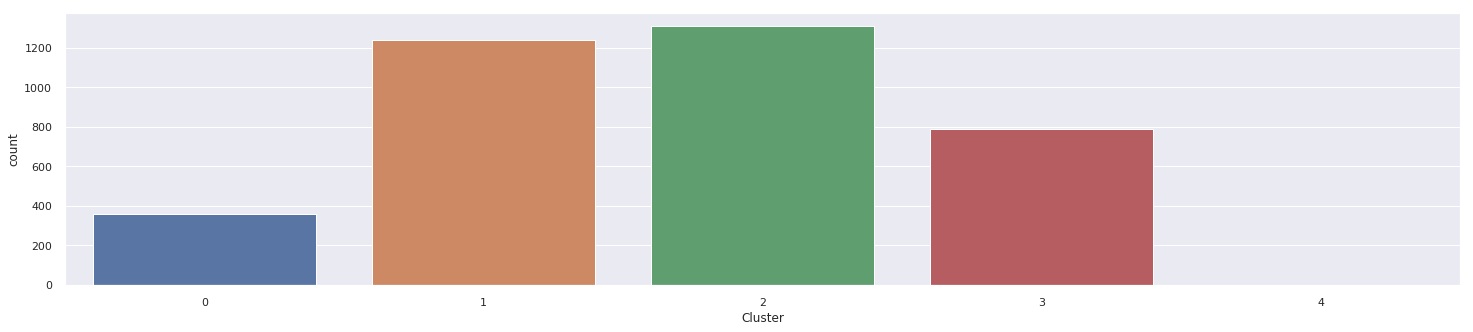

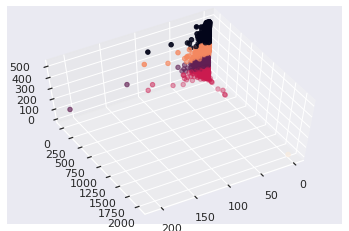

In [13]:
kmeans = KMeans(5)
kmeans.fit(db)
identified_clusters = kmeans.fit_predict(db)
data_with_clusters = db.copy()
data_with_clusters['Cluster'] = identified_clusters
print(kmeans.cluster_centers_)
print(identified_clusters)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=data_with_clusters)
data_with_clusters.groupby(['Cluster']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

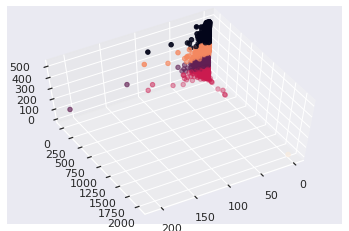

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

In [15]:
data_with_clusters[data_with_clusters['Cluster']==4]

,InvoiceNo,UnitPrice,avgitems,Cluster
3594,1,2033.1,1.0,4


In [16]:
kmeans.cluster_centers_


array([[4.49860724e+00, 2.68624629e+00, 4.00937163e+02],
       [4.46489104e+00, 3.06162468e+00, 1.55997996e+02],
       [3.32646834e+00, 5.73027434e+00, 6.68524971e+01],
       [4.85659898e+00, 2.69354075e+00, 2.64625183e+02],
       [1.00000000e+00, 2.03310000e+03, 1.00000000e+00]])

## K-Means with  normalized data

### Scale Data

In [17]:
scaler = StandardScaler()
x_scaled=scaler.fit(db)
x_scaled = scaler.fit_transform(db)
x_scaled

array([[ 9.85610419e-01, -2.03503047e-03, -5.05487418e-01],
       [ 2.96065827e+01, -4.91715951e-02, -4.44316536e-01],
       [ 1.22666532e-01,  1.53665481e-02,  1.12220025e+00],
       ...,
       [-4.52629392e-01,  3.25154449e-02, -1.07067980e+00],
       [-3.08805411e-01,  2.08510718e-02, -1.09350328e+00],
       [ 1.70473033e+00, -7.78228751e-02, -7.66556918e-01]])

### Elbow

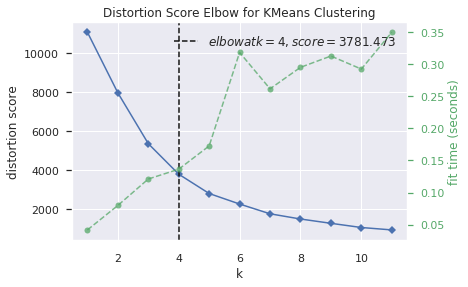

In [18]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show()     

### Kmeans

[1 1 3 ... 2 2 2]
[[4.49860724e+00 2.68624629e+00 4.00937163e+02]
 [4.46489104e+00 3.06162468e+00 1.55997996e+02]
 [3.32646834e+00 5.73027434e+00 6.68524971e+01]
 [4.85659898e+00 2.69354075e+00 2.64625183e+02]
 [1.00000000e+00 2.03310000e+03 1.00000000e+00]]


,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
0,2484,2484,2484
1,1,1,1
2,1204,1204,1204
3,9,9,9


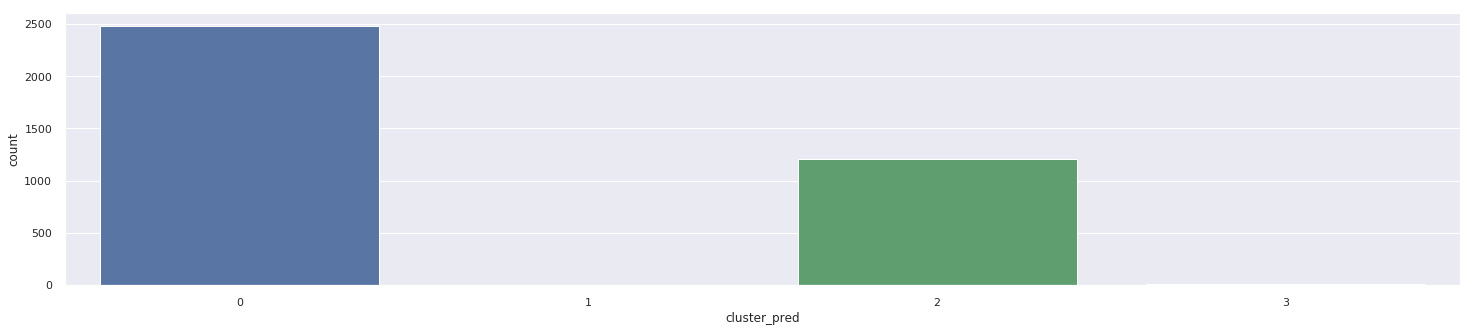

In [19]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
clusters_scaled = db.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(kmeans.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

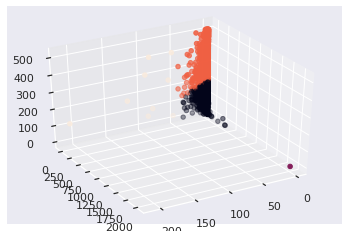

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

## Cure Algorithm

clusters: [[128.25, 2.577176486557603, 120.90058362804987], [3.4109704641350214, 4.616097402410298, 63.1816545895229], [1.75, 411.4925, 10.833333333333334], [4.302316293929713, 2.9018614360170543, 222.8390695997233], [1.0, 2033.1, 1.0]]
Sample:  /kaggle/working/pandas.txt 		Execution time:  0.7745710000000017 

[4, 1185, 4, 2504, 1]


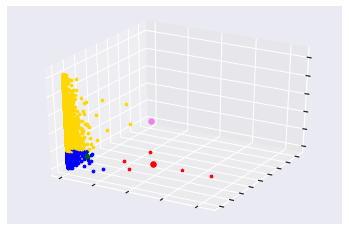

In [21]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)
    
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()
   



        
rec = db.to_records(index=False)
db.to_csv(r'/kaggle/working/pandas.txt', header=None, index=None, sep=' ', mode='a')
path= '/kaggle/working/pandas.txt'
template_clustering(5,path)


## Cure Algorithm at Normalized Data

clusters: [[29.606582672647058, -0.049171595059416304, -0.4443165364813065], [13.527061577595301, -0.05127296535742112, 0.446655113930668], [-0.026223045561712573, -0.015048566451871376, -6.351163200177511e-05], [-0.45262939234235855, 55.849795195703805, -1.5545375994522899]]
Sample:  /kaggle/working/pa2ndas.txt 		Execution time:  0.6097129999999993 

[1, 5, 3691, 1]


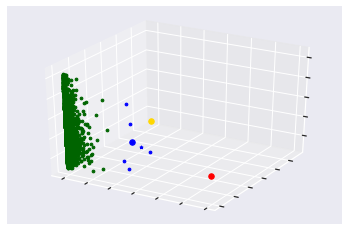

In [22]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)
    
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()
   


dtype = [('Col1','int32'), ('Col2','float32'), ('Col3','float32')]
index = ['Row'+str(i) for i in range(1, len(x_scaled)+1)]

x_sc1 = pd.DataFrame(x_scaled, index=index)

rec = x_sc1.to_records(index=False)
x_sc1.to_csv(r'/kaggle/working/pa2ndas.txt', header=None, index=None, sep=' ', mode='a')

path= '/kaggle/working/pa2ndas.txt'
template_clustering(4,path)


## DBSCAN with Normalized Data

,InvoiceNo,UnitPrice,avgitems
cluster_pred,,,
-1,44,44,44
0,3649,3649,3649
1,5,5,5


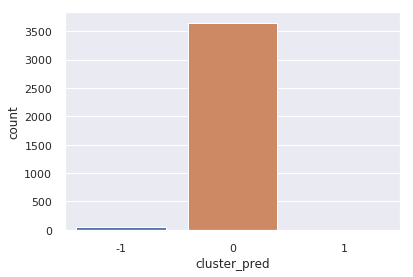

In [23]:

stscaler = StandardScaler().fit(db)
db11 = stscaler.transform(db)
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(db11)
clusters_scaled = db.copy()
clusters_scaled['cluster_pred']=dbsc.fit_predict(db11)
clusters_scaled
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()


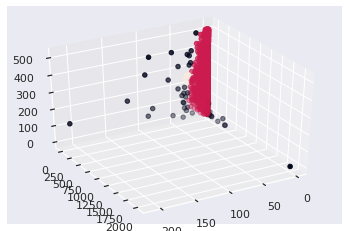

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['InvoiceNo']
yline=clusters_scaled['avgitems']
zline=clusters_scaled['UnitPrice']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(35, 60)

## DBSCAN 

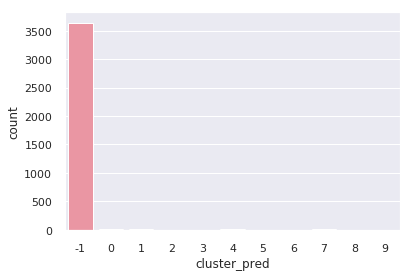

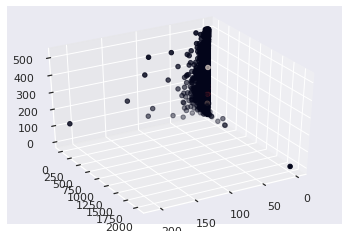

In [25]:
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(db)
data_with_clusters = db.copy()
data_with_clusters['cluster_pred']=dbsc.fit_predict(data_with_clusters)
data_with_clusters
ax = sns.countplot(x="cluster_pred", data=data_with_clusters)
data_with_clusters.groupby(['cluster_pred']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)

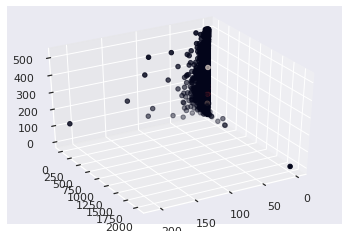

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['cluster_pred'])
ax.view_init(35, 60)